In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load data

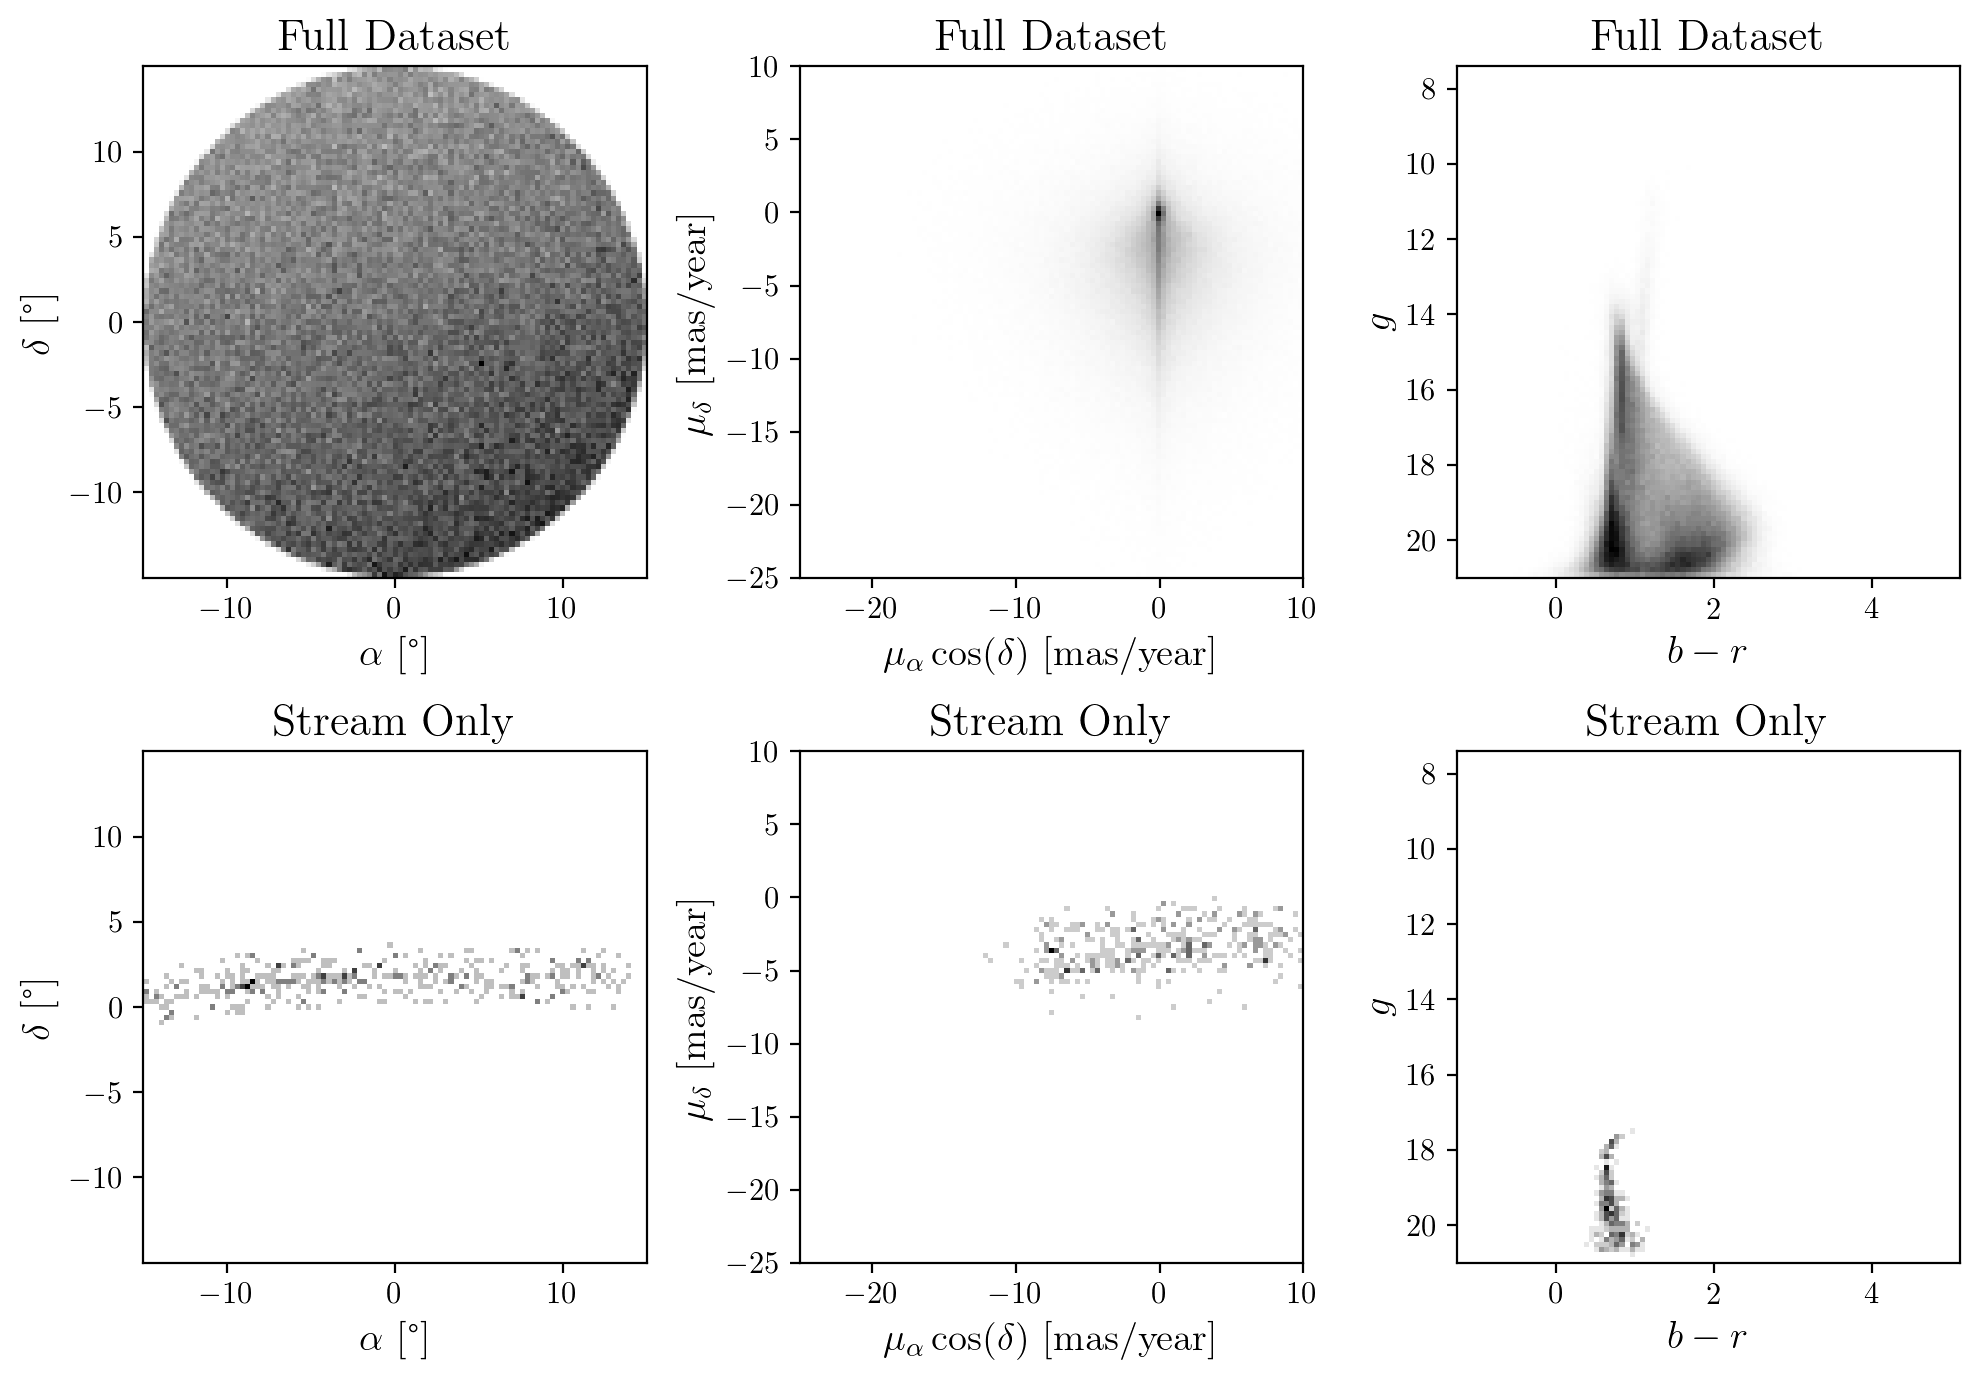

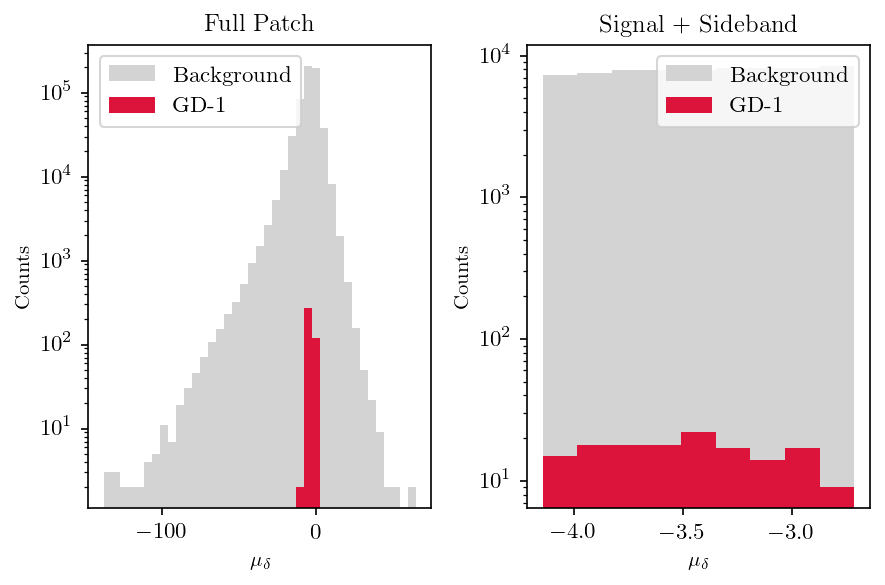

In [2]:
stream = "gd1_tail"
df, file = load_file(stream = stream)
visualize_stream(df, save_folder="gd1_tail")

Sideband region: [-7.0,-3.0]
Signal region: [-6.0,-3.1]
Total counts: SR = 128,211, SB = 38,237
Signal region has 230 stream and 127,981 bkg events (0.18%).
Sideband region has 14 stream and 38,223 bkg events (0.04%).
f_sig = 4.9X f_sideband.


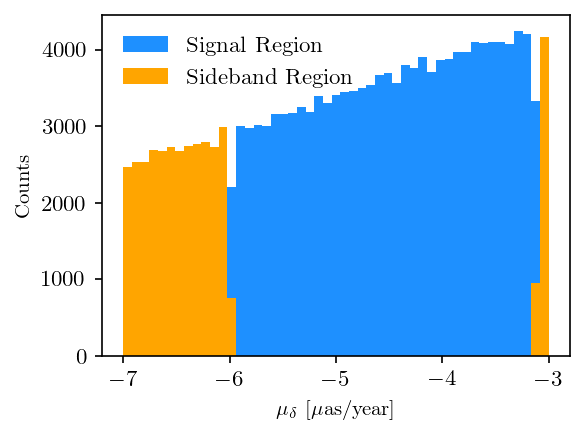

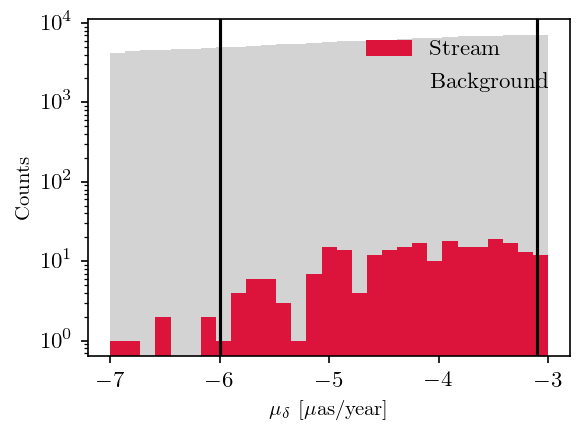

In [3]:
df_slice = signal_sideband(df, stream = stream)

# Train

In [4]:
print("Dataframe has {:,} stars, of which {:,} are stream stars.".format(
    len(df), 
    len(df[df.stream])))

Dataframe has 593,673 stars, of which 395 are stream stars.


[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]2022-10-12 06:14:26.571451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 06:14:28.446460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39749 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-10-12 06:14:30.466075: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1041/1041 [==============================] - 2s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:53<02:40, 53.45s/it]

1041/1041 [==============================] - 1s 767us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:39<01:38, 49.05s/it]

1041/1041 [==============================] - 1s 828us/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:24<00:47, 47.25s/it]

1041/1041 [==============================] - 1s 801us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

1041/1041 [==============================] - 1s 821us/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:45<02:15, 45.06s/it]

1041/1041 [==============================] - 1s 771us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:30<01:30, 45.16s/it]

1041/1041 [==============================] - 1s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:16<00:45, 45.75s/it]

1041/1041 [==============================] - 1s 1ms/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

1041/1041 [==============================] - 1s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:45<02:15, 45.29s/it]

1041/1041 [==============================] - 1s 812us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:31<01:31, 45.79s/it]

1041/1041 [==============================] - 1s 788us/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:17<00:45, 45.80s/it]

1041/1041 [==============================] - 1s 826us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

1041/1041 [==============================] - 1s 1ms/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:46<02:20, 46.98s/it]

1041/1041 [==============================] - 1s 990us/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:32<01:32, 46.31s/it]

1041/1041 [==============================] - 2s 1ms/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:18<00:45, 45.92s/it]

1041/1041 [==============================] - 1s 982us/step



[Step 2] Validation set (x3):   0%|          | 0/4 [00:00<?, ?it/s]

1041/1041 [==============================] - 1s 842us/step



[Step 2] Validation set (x3):  25%|██▌       | 1/4 [00:45<02:15, 45.09s/it]

1041/1041 [==============================] - 1s 1ms/step



[Step 2] Validation set (x3):  50%|█████     | 2/4 [01:30<01:30, 45.22s/it]

1041/1041 [==============================] - 1s 968us/step



[Step 2] Validation set (x3):  75%|███████▌  | 3/4 [02:14<00:44, 44.93s/it]

1041/1041 [==============================] - 1s 821us/step



[Step 1] k-fold: 100%|██████████| 5/5 [15:31<00:00, 186.32s/it]


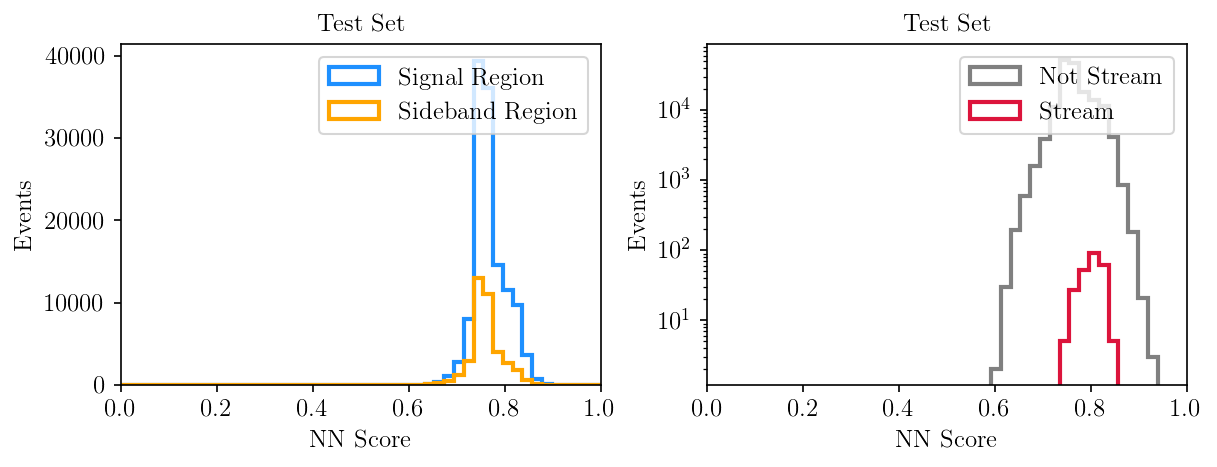

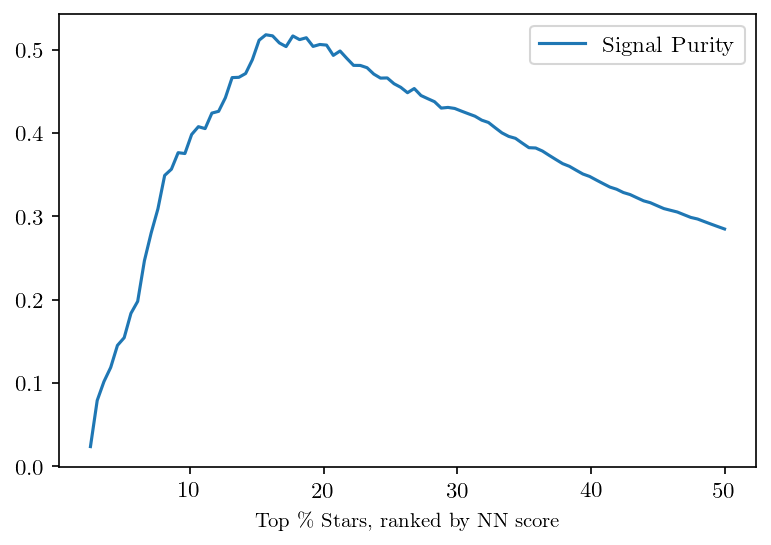

Top 50 stars: Purity = 0.0% 


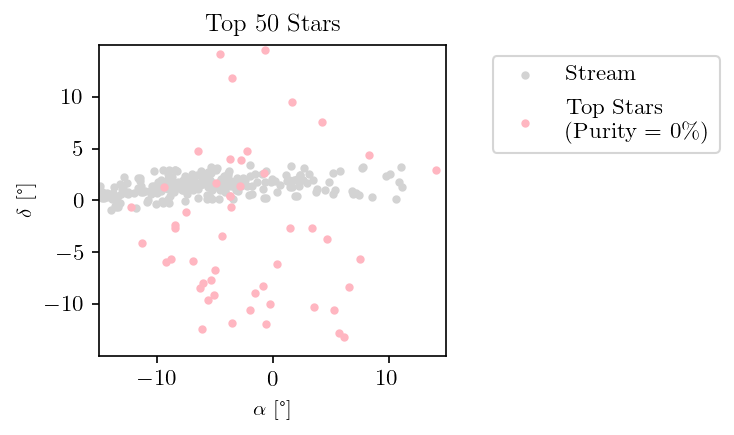

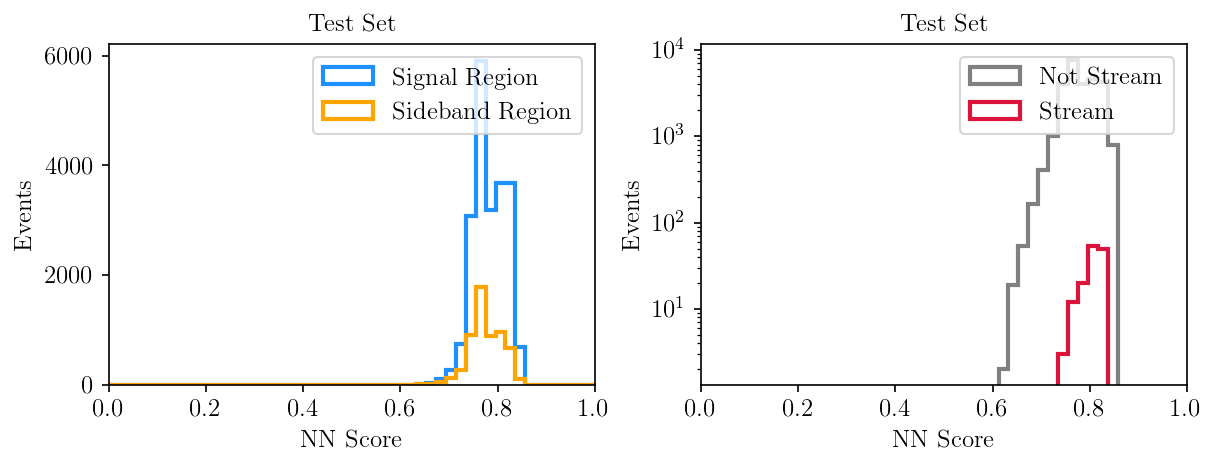

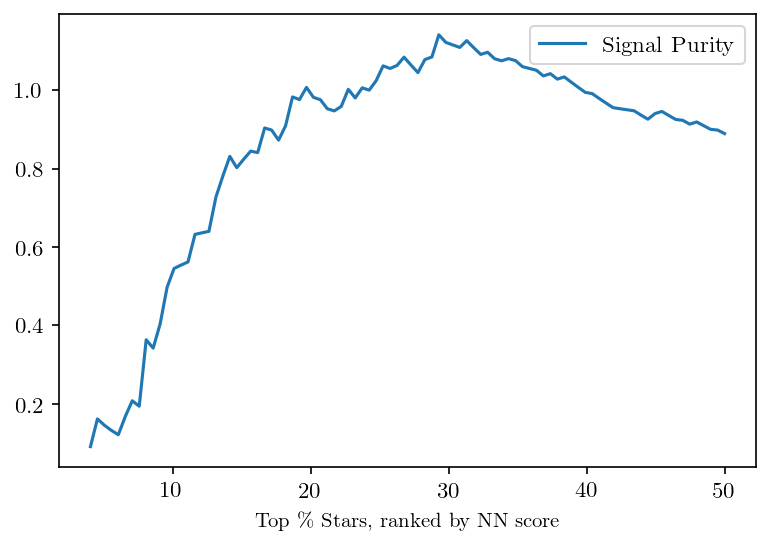

Top 50 stars: Purity = 0.0% 


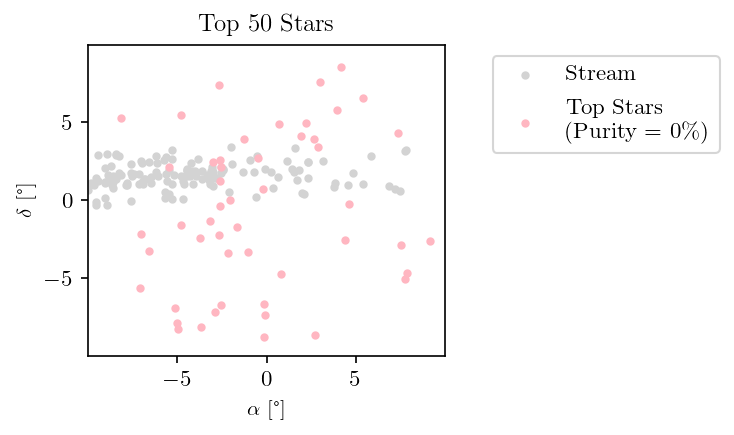

In [5]:
tf.keras.backend.clear_session()
df_test = train(df_slice, 
      n_folds = 5, 
      best_of_n_loops = 3,
      layer_size = 50, 
      batch_size = 10000, 
      dropout = 0.2, 
      epochs = 100, 
      patience = 20,
      verbose = False,
      save_folder = "gd1_tail", 
                        )